In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import math
import random
from sklearn import preprocessing
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
result_list = []
for time in range(1, 11):
    Seq2Seq_model_1.train()
    for i, (hist, target) in enumerate(trainloader_1, 1):
        hist = hist.float()
        output = Seq2Seq_model_1(hist).to(device)
        output = output.reshape(-1, 1)
        target = target.float().reshape(-1, 1).to(device)
        loss = criterion_1(output, target)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        scheduler_1.step()
    Seq2Seq_model_1.eval()  # 设置模型为评估模式
    # 假设您的测试数据是一个张量 input_data
    output = Seq2Seq_model_1(X1fold_tensor.float())
    result_list.append(output.detach().numpy().reshape(-1, 1))
    # 创建一个空的 DataFrame

result_df = pd.DataFrame(np.squeeze(result_list))
result_df = result_df.T
grah_df = result_df.iloc[22:44]
grah_df
df_y = pd.DataFrame(np.squeeze(Y1fold_tensor.cpu().numpy().reshape(-1, 1)))
graph_df_y = df_y.iloc[22:44]
grah_df.iloc[0:15] = graph_df_y.iloc[0:15]
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有x和y的数据
x = grah_df.to_numpy()
y = graph_df_y.to_numpy()

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制x的每一列数据
for i in range(10):
    ax.plot(x[:, i], label=f'x{i + 1}', color='blue')

# 绘制y的数据
ax.plot(y, label='y', color='red')

# 添加标题和标签
ax.set_title('tendency_prediction')
ax.set_xlabel('month')
ax.set_ylabel('Chlo_a')

# 添加图例
ax.legend()
ax.set_xticks(range(0, 23))
ax.set_yticks(range(0, 30, 3))
fig.savefig('0313S2S15to8_tendency_prediction_8months.jpg')
# 显示图形
plt.show()


In [3]:
data = pd.read_excel('zone_merged_reordered_136(no bot).xlsx').astype('float64')
features = data.columns
# 使用每列的众数填充该列的缺失值
for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global data_np
data_np = data.to_numpy()[:, :]
#归一化
min_max_scaler = preprocessing.MinMaxScaler()
data_np_scale = min_max_scaler.fit_transform(data_np)
#取最后一列
original_chlo_data = data_np[:, -1]
global max_chlo
max_chlo = np.max(original_chlo_data)
chlo_data = data_np_scale[:, -1]
"Optimal parameters"
global feat_num, use_len
feat_num = data_np.shape[1]
use_len = 15
pred_len = 8
hidden_dim = 128
batch_size = 64


#生成用于训练或测试时间序列预测模型的样本集
def create_index_set(rain_data, data_np, use_len, pred_len):
    sample_size = len(rain_data) - (use_len + pred_len - 1)

    X_sample = np.zeros((sample_size, use_len, data_np.shape[1]))
    Y_sample = np.zeros((sample_size, pred_len))

    for i in range(use_len, len(rain_data) - pred_len + 1):
        Y_sample[i - use_len] = rain_data[i:i + pred_len]
        X_sample[i - use_len] = data_np_scale[i - use_len:i, :]

    X_sample = X_sample.reshape(len(X_sample), use_len, data_np.shape[1])
    Y_sample = Y_sample.reshape(len(Y_sample), pred_len, 1)

    return X_sample, Y_sample


X_sample, Y_sample = create_index_set(original_chlo_data, data_np_scale, use_len, pred_len)
#分割训练集和测试集，分成3份，用于三次训练
X_tr, X_1fold, Y_tr, Y_1fold = train_test_split(X_sample, Y_sample, test_size=0.3, random_state=42)
X_2fold, X_3fold, Y_2fold, Y_3fold = train_test_split(X_tr, Y_tr, test_size=0.3, random_state=42)

X1fold_tensor = torch.from_numpy(X_1fold).to(device)
Y1fold_tensor = torch.from_numpy(Y_1fold).to(device)

X2fold_tensor = torch.from_numpy(X_2fold).to(device)
Y2fold_tensor = torch.from_numpy(Y_2fold).to(device)

X3fold_tensor = torch.from_numpy(X_3fold).to(device)
Y3fold_tensor = torch.from_numpy(Y_3fold).to(device)

In [3]:
shap_values_1fold=np.load('Explanation\shap_values_1fold411.npy')

In [4]:
shap_values_1fold= shap_values_1fold.transpose((0,1,3,2))  

In [5]:
shap_values_1fold.shape

(8, 2082, 37, 15)

In [6]:
def shap_for_month(shap_values,mon,lt): #mon: 1~12 representing Jan to Dec，lt：1~12 representing lead month
    
    lt = lt - 1 
    feat_index_tab = []
    feat_x_tab = []

    feat_name = features.tolist()
    feat_x_name = ['X' + str(i) for i in range(1, feat_num+1)]
    minus_time = [i for i in range(1,use_len+1)]
    t_minus_time = ['t-'+str(k) for k in minus_time]
    
    for i in range(feat_num): 
        for j in range(use_len): 
            feat_index_tab.append(feat_name[i]+'_'+t_minus_time[j])
            feat_x_tab.append(feat_x_name[i]+'_'+t_minus_time[j])
            
    shap_lt = shap_values[lt] #shap_lt shape: 1177,13,12
    if lt <= mon-1:
        begin = mon-lt-1 
        mon_y_rain = data_np[mon+11::12,0]
    else:
        begin = mon-lt+11
        mon_y_rain = data_np[mon+23::12,0]
        
    shap_lt_mon = shap_lt[begin::use_len]  #shap_lt_mon: num_mon,feat_num,use_len
    
    #Calculate the attribution for each feature
    
    feat_sum = np.sum(shap_lt_mon,axis=2)  
    feat_shap_score = np.zeros((feat_num,))
    for i in range(feat_num):
        feat_shap_score[i] = np.mean((abs(feat_sum[:,i])))
    sort_feat_shap = np.sort(feat_shap_score)[::-1]    
    sort_feat_index = feat_shap_score.argsort()[-1::-1]      
    sort_feat_name = [feat_name[k] for k in sort_feat_index]  
    sort_feat_x_name = [feat_x_name[k] for k in sort_feat_index]  
    feat_importance = pd.DataFrame(data=[sort_feat_name,sort_feat_x_name,sort_feat_shap,sort_feat_index],index=\
                 ['sort_feat_name','sort_feat_x_name','sort_feat_shap','sort_feat_index']).transpose()
    
    #Calculate the attribution for each time step
    
    time_sum = np.sum(shap_lt_mon,axis=1)  
    time_shap_score = np.zeros((use_len,))
    for i in range(use_len):
        time_shap_score[i] = np.mean((abs(time_sum[:,i])))
    sort_time_shap = np.sort(time_shap_score)[::-1]    
    sort_time_index = time_shap_score.argsort()[-1::-1]      
    sort_time_name = [t_minus_time[k] for k in sort_time_index]  
    time_importance = pd.DataFrame(data=[sort_time_name,sort_time_shap,sort_time_index],index=\
                 ['sort_time_name','sort_time_shap','sort_time_index']).transpose()
    
    shap_lt_mon_resha = shap_lt_mon.reshape(-1,feat_num*use_len)

    cores_feat = np.zeros(shap_lt_mon_resha.shape)
    for i in range(cores_feat.shape[0]):   
        for j in range(feat_num):          
            cores_feat[i,j*12:(j+1)*12] = data_np[begin+12*i:begin+12+12*i,j]           
            
            
    shap_score = np.zeros((feat_num*use_len,))
    for i in range(feat_num*use_len):
        shap_score[i] = np.mean((abs(shap_lt_mon_resha[:,i])))
    sort_shap_score = np.sort(shap_score)[::-1]    
    sort_shap_index = shap_score.argsort()
    sort_shap_index = sort_shap_index[-1::-1]      
    sort_shap_feat_name = [feat_index_tab[k] for k in sort_shap_index]  
    sort_shap_x_name = [feat_x_tab[k] for k in sort_shap_index]  
    
    top = 10
    sort_shap_allpoint = np.zeros([shap_lt_mon.shape[0],top])
    sort_shap_allfeat = np.zeros([shap_lt_mon.shape[0],top])

    for i in range(top):  
        
        sort_shap_allpoint[:,i] = shap_lt_mon_resha[:,sort_shap_index[i]]     
        sort_shap_allfeat[:,i] = cores_feat[:,sort_shap_index[i]]      
    
    sort_shap_feat_scaler = preprocessing.MinMaxScaler()
    sort_shap_allfeat_scale = sort_shap_feat_scaler.fit_transform(sort_shap_allfeat)
    
    feat_time_importance = pd.DataFrame(data=[sort_shap_score,sort_shap_feat_name,sort_shap_x_name],index=\
                 ['sort_shap_score','sort_shap_feat_name','sort_shap_x_name']).transpose()
    
    return feat_time_importance,sort_shap_allpoint,sort_shap_allfeat_scale,sort_shap_allfeat,mon_y_rain,\
            feat_importance,time_importance 

In [16]:
feat_time_importance1,sort_shap_allpoint1,sort_shap_allfeat_scale1,\
 sort_shap_allfeat1,mon_y_rain1,feat_importance1,time_importance1 = shap_for_month(shap_values_1fold,1,8)

In [18]:
feat_time_importance1.to_csv(r'Explanation\feat_time_importance1_411.csv')
feat_importance1.to_csv(r'Explanation\feat_importance1_411.csv')
time_importance1.to_csv(r'Explanation\time_importance1_411.csv')

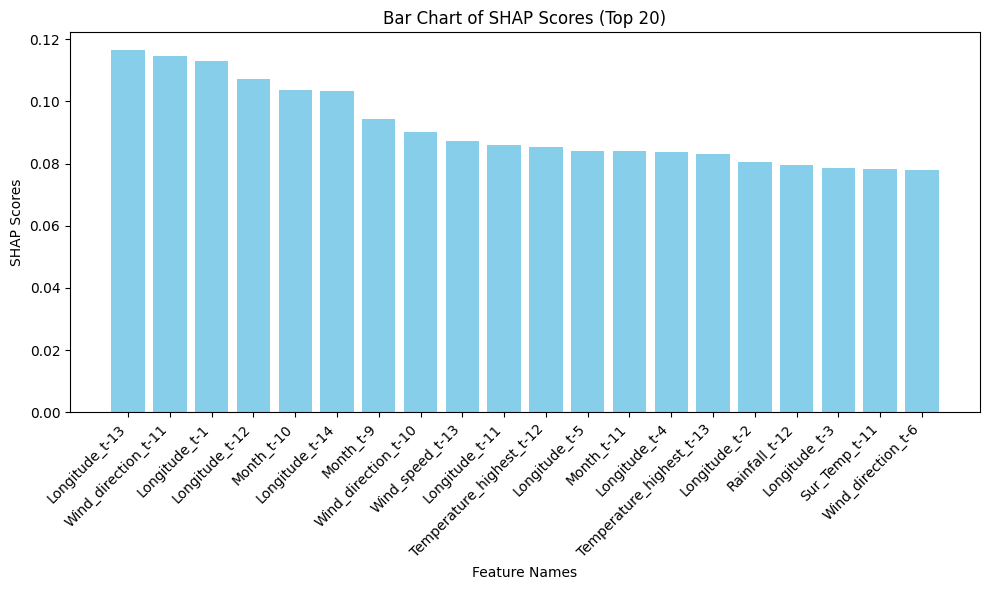

In [19]:
df = pd.read_csv(r'Explanation\feat_time_importance1_411.csv')  # 替换为你的DataFrame文件路径和文件名
# 提取纵坐标和横坐标数据（仅前20条数据）
y_values = df['sort_shap_score'].head(20)  # 使用'sort_shap_score'作为纵坐标
x_labels = df['sort_shap_feat_name'].head(20)  # 使用'sort_shap_feat_name'作为横坐标标签

# 绘制柱状图
plt.figure(figsize=(10, 6))  # 设置画布大小
plt.bar(x_labels, y_values, color='skyblue')  # 绘制柱状图，设置颜色为天蓝色
plt.xlabel('Feature Names')  # 设置横坐标标签
plt.ylabel('SHAP Scores')  # 设置纵坐标标签
plt.title('Bar Chart of SHAP Scores (Top 20)')  # 设置标题
plt.xticks(rotation=45, ha='right')  # 旋转横坐标标签，并右对齐
plt.tight_layout()  # 调整布局，防止标签重叠
plt.savefig('SHAP_Score_feat_time.png')


In [57]:
shap_values_1fold_test=np.load('Explanation\shap_values_1fold411.npy')

In [58]:
X1fold_tensor_test=X1fold_tensor.reshape(-1,37)

In [59]:
X1fold_tensor_test=X1fold_tensor_test.cpu().numpy()

In [61]:
shap_values_1fold_test_sub = shap_values_1fold_test[0, :,:, :]

In [63]:
shap_values_1fold_test_sub=shap_values_1fold_test_sub.reshape(-1,37)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


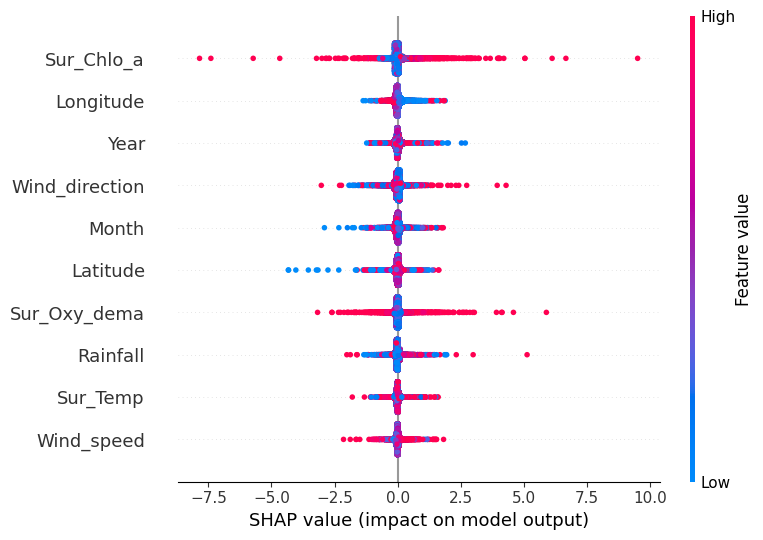

In [67]:
#shap summary plot
shap.summary_plot(shap_values_1fold_test_sub, X1fold_tensor_test,feature_names=features,max_display=10,show=False, color='blue')
plt.savefig('20240420paper/feat_shap_summary_plot.png')